<a href="https://colab.research.google.com/github/HeNeos/Mechanical/blob/master/Finite_Element_Analysis/Extended_truss_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
def NaiveMultiply(A,B):
    C = np.zeros((A.shape[0],B.shape[1]))
    for i in range(0,C.shape[0]):
        for j in range(0,C.shape[1]):
            aux = 0
            for k in range(0,A.shape[1]):
                aux += A[i][k]*B[k][j]
            C[i][j] = aux
    return C
 
def nextPowerofTwo(n):
    return int(2**(ceil(log2(n))))
 
def ModifyMatrix(A):
    newA = A
    if(A.shape[1]%2 == 1):
        aux = np.zeros((A.shape[0],A.shape[1]+1))
        aux = np.insert(A,A.shape[1],0,axis=1)
        newA = aux
    if(newA.shape[0]%2 == 1):
        aux = np.zeros((newA.shape[0]+1,newA.shape[1]))
        aux = np.insert(newA,newA.shape[0],0,axis=0)
        newA = aux
    return newA
 
def FastMultiply(oldA,oldB):
    rows = oldA.shape[0]
    columns = oldB.shape[1]
    if(rows <= 2 or columns <=2 or oldA.shape[1] <= 2 or oldB.shape[0] <= 2):
        return np.matmul(oldA,oldB)
    
    A = ModifyMatrix(oldA)
    B = ModifyMatrix(oldB)
    N1 = A.shape[0]
    N2 = A.shape[1]
    N3 = B.shape[0]
    N4 = B.shape[1]
    
 
    a = A[0:N1//2,0:N2//2]
    b = A[0:N1//2,N2//2:N2//2+N2//2]
    c = A[N1//2:N1//2+N1//2,0:N2//2]
    d = A[N1//2:N1//2+N1//2,N2//2:N2//2+N2//2]
    
    e = B[0:N3//2,0:N4//2]
    f = B[0:N3//2,N4//2:N4//2+N4//2]
    g = B[N3//2:N3//2+N3//2,0:N4//2]
    h = B[N3//2:N3//2+N3//2,N4//2:N4//2+N4//2]
    
    
    p1 = FastMultiply(a,(f-h))
    p3 = FastMultiply((c+d),e)
    p2 = FastMultiply((a+b),h)
    p4 = FastMultiply(d,(g-e))
    p5 = FastMultiply((a+d),(e+h))
    p6 = FastMultiply((b-d),(g+h))
    p7 = FastMultiply((a-c),(e+f))
    
    
    C = np.zeros((rows,columns))
    
    c11 = p5 + p4 - p2 + p6
    c12 = p1 + p2
    c21 = p3 + p4
    c22 = p1 + p5 - p3 - p7
    
 
    
    for i in range(0,N1//2):
        for j in range(0,N4//2):
            C[i][j] = c11[i][j]
            if(j + N4//2 < columns):
                C[i][j+N4//2] = c12[i][j]
            if(i + N1//2 < rows):
                C[i+N1//2][j] = c21[i][j]
                if(j + N4//2 < columns):
                    C[i+N1//2][j+N4//2] = c22[i][j]
    return C

In [3]:
def conjugate_grad(A, b, x=None):
    n = b.shape[0]
    if not x:
        x = np.ones((n,1))
    r = np.dot(A, x) - b
    p = - r
    r_k_norm = FastMultiply(np.transpose(r), r)
    for i in range(2*n):
        Ap = np.dot(A, p)
        
        alpha = r_k_norm /FastMultiply(np.transpose(p), Ap)
        x += alpha * p
        r += alpha * Ap
        r_kplus1_norm = FastMultiply(np.transpose(r), r)
        beta = r_kplus1_norm / r_k_norm
        r_k_norm = r_kplus1_norm
        p = beta * p - r
    return x

In [4]:
NodesCondition = []
ForcesCondition = []

def DistNodes(f,s):
    if(s[0] == f[0]):
        aux = np.pi/2
        if(s[1] < f[1]):
             aux *= -1
        return (np.sqrt((s[0]-f[0])**2+(s[1]-f[1])**2),aux)
    else:
        aux = np.arctan((s[1]-f[1])/(s[0]-f[0]))
    if(aux < 0 and s[1] > f[1]):
        aux += np.pi
    if(s[1] < f[1]):
        aux += np.pi
        if(s[0] > f[0]):
            aux += np.pi

    return (np.sqrt((s[0]-f[0])**2+(s[1]-f[1])**2),aux)
 
 
def UBoundaryCondition(nU,u,i):
    nU[i][0] = u
    NodesCondition.append(i)
 
def FBoundaryCondition(nF,f,i):
    nF[i][0] += f
    ForcesCondition.append(i)
    
def AssemblyStiffness(nStiffnessMatrix,k,i,j):
    for p in range(0,2):
        for m in range(0,2):
            nStiffnessMatrix[2*i+p][2*i+m] += k[p][m]
            nStiffnessMatrix[2*i+p][2*j+m] += k[p][2+m]
            nStiffnessMatrix[2*j+p][2*i+m] += k[p+2][m]
            nStiffnessMatrix[2*j+p][2*j+m] += k[p+2][2+m]
 
def Initialize(nStiffnessMatrix,nU,nF):
    for i in range(0,Nodes):
        nU[i][0] = 0
        nF[i][0] = 0
    for i in range(0,NumberOfElement):
        AssemblyStiffness(nStiffnessMatrix,K[i],int(Elements[i][0]),int(Elements[i][1]))

def TMatrix(nT,i,angle):
    nT[2*i][2*i] = np.cos(angle)
    nT[2*i][2*i+1] = np.sin(angle)
    nT[2*i+1][2*i] = -np.sin(angle)
    nT[2*i+1][2*i+1] = np.cos(angle)

def ApplyT(nStiffnessMatrix, nT):
    return FastMultiply(FastMultiply(nT,nStiffnessMatrix),np.transpose(nT))

def PreSolvingStiffness(nStiffnessMatrix):
    nsize = Nodes-len(NodesCondition)
    newStiffness = np.zeros((nsize,nsize))
    contr = -1
    for i in range(0,Nodes):
        contc = -1
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        for j in range(0,Nodes):
            flagc = False
            for k in range(0,len(NodesCondition)):
                if(j == NodesCondition[k]):
                    flagc = True
                    break
            if(flagc):
                continue
            contc += 1
            newStiffness[contr][contc] = nStiffnessMatrix[i][j]
    return newStiffness
 
 
def PreSolvingF(nF,nS,nU):
    nsize = Nodes-len(NodesCondition)
    newF = np.zeros(nsize).reshape(nsize,1)
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            for k in range(0,Nodes):
                nF[k][0] = nF[k][0]-nS[k][i]*nU[i][0]
            continue
 
            
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        newF[contr][0] = nF[i][0]
    
    return newF
                      
 
def Solve(nStiffnessMatrix,nU,nF):
    newStiffness = PreSolvingStiffness(nStiffnessMatrix)
    newF = PreSolvingF(nF,nStiffnessMatrix,nU)
    u = conjugate_grad(newStiffness,newF)    
    contr = -1
    for i in range(0,Nodes):
        flagr = False
        for k in range(0,len(NodesCondition)):
            if(i == NodesCondition[k]):
                flagr = True
                break
        if(flagr):
            continue
        contr += 1
        nU[i][0] = u[contr][0]
    nnF = FastMultiply(StiffnessMatrix,nU)
    return nU,nnF

In [221]:
NodesCondition = []
n = 80
NumberOfElement = 6
Nodes = 5+(n-1)*NumberOfElement
Nodes *= 2
NumberOfElement *= n

h = 1500e-3
E = 3.2e8 #MPA
K = []
A = (0.25*np.pi*(50e-3)**2)*np.ones(Nodes)
L = []
P_A = 5000e-3
P_B = 4200e-3
P_C = 2500e-3
P_E = 3000e-3

PosNodes = []
for i in range(0,n+1):
    PosNodes.append((0,i*h/n))
for i in range(1,n+1):
    PosNodes.append((0+i*h/n,h-i*h/n))
for i in range(1,n+1):
    PosNodes.append((h,i*h/n))
for i in range(1,n+1):
    PosNodes.append((h,h+i*h/n))
for i in range(1,n):
    PosNodes.append((h-i*h/n,2*h-i*h/n))
for i in range(1,n):
    PosNodes.append((0+i*h/n,h))

PosNodes = np.array(PosNodes)

Elements = []
for i in range(0,5*n-1):
    Elements.append((i,i+1))
Elements.append((5*n-1,n))
Elements.append((n,5*n))
for i in range(5*n,6*n-2):
    Elements.append((i,i+1))
Elements.append((6*n-2,3*n))
Elements = np.array(Elements)
#PosNodes = np.array([(0,0),(h,0),(0,h),(h,h),(h,2*h)])
#Elements = np.array([(0,2),(1,2),(1,3),(2,3),(2,4),(3,4)])

for i in range(0,NumberOfElement):
    L.append(DistNodes(PosNodes[Elements[i][0]],PosNodes[Elements[i][1]]))

L = np.array(L)

for i in range(0,NumberOfElement):
    aux = np.zeros((4,4))
    angle = L[i][1]
    rows = [np.cos(angle),np.sin(angle),-np.cos(angle),-np.sin(angle)]
    cols = [np.cos(angle),np.sin(angle),-np.cos(angle),-np.sin(angle)]
    for j in range(0,4):
        for k in range(0,4):
            aux[j][k] = rows[j]*cols[k]
    aux = aux*E*A[i]/L[i][0]
    K.append(aux)


StiffnessMatrix = np.zeros((Nodes,Nodes))

U = np.zeros(Nodes).reshape(Nodes,1)
F = np.zeros(Nodes).reshape(Nodes,1)

Initialize(StiffnessMatrix,U,F)

#Node in UBoundary = Node*2+(x=0,y=1)
UBoundaryCondition(U,0,2*0+0) #Nodo 0 en X
UBoundaryCondition(U,0,2*0+1) #Nodo 0 en Y
UBoundaryCondition(U,0,2*2*n+0) #Nodo 3 en X
UBoundaryCondition(U,0,2*2*n+1) #Nodo 3 en Y

FBoundaryCondition(F,-P_C,2*n+0) #Nodo 2 en X
FBoundaryCondition(F,-P_E,2*3*n+0) #Nodo 3 en X
FBoundaryCondition(F,-P_B,2*4*n+0) #Nodo 4 en X
FBoundaryCondition(F,P_A,2*4*n+1) #Nodo 4 en Y


U,F=Solve(StiffnessMatrix,U,F)
print("Stiffness Matrix:\n",StiffnessMatrix,'\n')
print("Displacements:\n",U,'\n')
print("Forces:\n",F)


Stiffness Matrix:
 [[ 1.25643582e-25  2.05191541e-09 -1.25643582e-25 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.05191541e-09  3.35103216e+07 -2.05191541e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.25643582e-25 -2.05191541e-09  2.51287163e-25 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   6.70206433e+07  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]] 

Displacements:
 [[ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.00000000e+00]
 [-4.14604519e-07]
 [ 1.00000000e+00]
 [-8.31450279e-07]
 [ 1.00000000e+00]
 [-1.25060661e-06]
 [ 1.00000000e+00]
 [-1.66654424e-06]
 [ 1.00000000e+00]
 [-2.08170246e-06]
 [ 1.00000000e+00]
 [-2.49497247e-06]
 [ 1.00000000e+00]
 [-2.90923045e-06]
 [ 1.00000000e+00]
 [-3

In [222]:
ElementDisplacement = []
for i in range(0,NumberOfElement):
    Node1 = Elements[i][0]
    Node2 = Elements[i][1]
    ElementDisplacement.append([(U[2*Node1][0],U[2*Node1+1][0]),(U[2*Node2][0],U[2*Node2+1][0])])
Stress = []
for i in range(0,NumberOfElement):
    C = np.cos(L[i][1])
    S = np.sin(L[i][1])
    dd = ElementDisplacement[i]
    ss = -dd[0][0]*C - dd[0][1]*S + dd[1][0]*C+dd[1][1]*S
    Stress.append(ss*E/L[i][0])
Stress = 1e-3*np.array(Stress)
print("Esfuerzos (MPa)")
print(Stress)

Esfuerzos (MPa)
[-7.07591713 -7.11416763 -7.15360138 -7.09866886 -7.08536692 -7.05314159
 -7.0700028  -7.13383369 -7.09717652 -7.04831832 -7.03320143 -7.10197172
 -7.11707653 -7.07646458 -7.08912499 -7.08279189 -7.08363255 -7.06237427
 -7.08212087 -7.10484456 -7.03775642 -7.02332969 -7.0454802  -7.08851665
 -7.07828123 -7.03132543 -7.05714586 -7.0458697  -7.06400206 -7.09613463
 -7.06927524 -7.03897992 -7.00444873 -7.0526504  -7.0735096  -7.04151416
 -7.00369081 -6.9646407  -7.01693794 -7.06274546 -7.06445683 -6.99843924
 -6.97063645 -7.0703019  -7.08919654 -7.06401631 -7.02072607 -7.0192089
 -7.06848365 -7.06978379 -7.09100822 -7.05453788 -7.05494514 -7.11140651
 -7.09095525 -7.10139103 -7.12069236 -7.12346414 -7.06876282 -7.0698516
 -7.14385923 -7.10318576 -7.06520886 -7.05993612 -7.07074497 -7.06181401
 -7.05852888 -7.10788003 -7.03665322 -6.99924735 -7.05281786 -7.09176982
 -7.08203355 -6.99232913 -6.99473899 -7.03634759 -7.04846625 -7.04907918
 -6.9997826  -6.99652949  6.92588677 

In [233]:
heatmap = -2*np.ones((2*n,n))
heatmap[2*n-1][0] = 26.4
taked = 6
for i in range(0,n):
    for j in range(0,taked):
        heatmap[i][j] = abs(Stress[i])
    
for i in range(0,n):
    for j in range(0,taked):
        heatmap[i][n-1-j] = abs(Stress[2*n+i-1])

for i in range(0,n):
    for j in range(0,taked):
        heatmap[i+n][n-1-j] = abs(Stress[3*n+i-1])

for i in range(0,n):
    for j in range(0,taked):
        heatmap[n-1-j][i] = abs(Stress[5*n+i-1])

for i in range(0,n):
    for j in range(0,(taked+4)//2):
        heatmap[max(0,n-1-i-j)][i] = abs(Stress[n+i-1])
        heatmap[max(0,n-1-i+j)][i] = abs(Stress[n+i-1])

for i in range(0,n):
    for j in range(0,(taked+4)//2):
        heatmap[2*n-i-1][max(0,n-i-1-j)] = abs(Stress[4*n+i-1])
        heatmap[2*n-i-1][min(n-1,n-i-1+j)] = abs(Stress[4*n+i-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


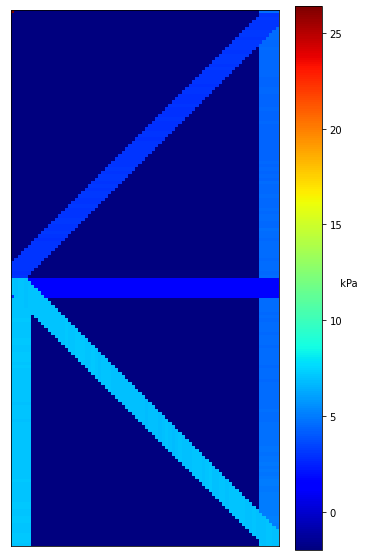

In [234]:
plt.figure(figsize=(6,10))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,origin="lower",cmap='jet',interpolation='nearest')
plt.colorbar().set_label('  kPa',rotation=0)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC3/Stress1.pdf')

In [235]:
heatmap = 0*np.ones((2*n,n))
heatmap[2*n-1][0] = 13
taked = 6
for i in range(0,n):
    for j in range(0,taked):
        heatmap[i][j] = abs(Stress[i])
    
for i in range(0,n):
    for j in range(0,taked):
        heatmap[i][n-1-j] = abs(Stress[2*n+i-1])

for i in range(0,n):
    for j in range(0,taked):
        heatmap[i+n][n-1-j] = abs(Stress[3*n+i-1])

for i in range(0,n):
    for j in range(0,taked):
        heatmap[n-1-j][i] = abs(Stress[5*n+i-1])

for i in range(0,n):
    for j in range(0,(taked+4)//2):
        heatmap[max(0,n-1-i-j)][i] = abs(Stress[n+i-1])
        heatmap[max(0,n-1-i+j)][i] = abs(Stress[n+i-1])

for i in range(0,n):
    for j in range(0,(taked+4)//2):
        heatmap[2*n-i-1][max(0,n-i-1-j)] = abs(Stress[4*n+i-1])
        heatmap[2*n-i-1][min(n-1,n-i-1+j)] = abs(Stress[4*n+i-1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


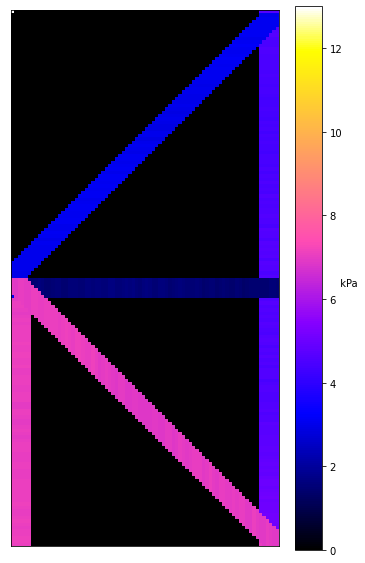

In [236]:
plt.figure(figsize=(6,10))
plt.grid(False)
plt.axes().xaxis.set_visible(False)
plt.axes().yaxis.set_visible(False)
plt.imshow(heatmap,origin="lower",cmap='gnuplot2',interpolation='nearest')
plt.colorbar().set_label('  kPa',rotation=0)
#plt.savefig('/content/drive/My Drive/Colab Notebooks/MC516/PC3/Stress2.pdf')
